In [1]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger
import torch
import scipy as sp
import json
import numpy as np
from glob import glob
import anndata
import pandas as pd 
from src.vae import CrossSpeciesVAE
from src.data import CrossSpeciesDataModule
import pickle
from sklearn.metrics import adjusted_mutual_info_score
import scanpy as sc
import matplotlib.pyplot as plt
import umap

fn1 = '../samap/example_data/planarian.h5ad'
fn2 = '../samap/example_data/schistosome.h5ad'
fn3 = '../samap/example_data/hydra.h5ad'

eggnogs = '../samap/example_data/eggnog/*'

adata1 = anndata.read_h5ad(fn1)
adata2 = anndata.read_h5ad(fn2)
adata3 = anndata.read_h5ad(fn3)
adata3.var_names = pd.Index([i.split('_')[-1] for i in adata3.var_names])

/opt/jupyter-envs/generate-cross-species/atar-vscode/conda/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# gene_embeddings, gene_ids = pickle.load(open('species_tsvd_gene_embeddings.pkl','rb'))
# gene_embeddings={k: torch.tensor(v) for k,v in gene_embeddings.items()}
homology_edges, homology_scores = pickle.load(open('species_homology_info.pkl','rb'))

batch_size = 128
species_data = {
    "planarian": adata1,
    "schisto": adata2,
    "hydra": adata3,
}

data_module = CrossSpeciesDataModule(
    species_data = species_data,
    batch_size=batch_size,
    num_workers=0,
    val_split=0.1,
    test_split=0.1,
    seed=0
)
data_module.setup()

species_vocab_sizes = data_module.species_vocab_sizes

# Initialize the model using data module properties
model = CrossSpeciesVAE(
    species_vocab_sizes=species_vocab_sizes,
    homology_edges=homology_edges,
    homology_scores=homology_scores,
    n_latent=128,
    hidden_dims=[128],
    dropout_rate=0.2,
    base_learning_rate=1e-3,
    batch_size=batch_size,
    base_batch_size=32,
    min_learning_rate=1e-5,
    warmup_epochs=1.0,
    species_embedding_dim=32,
    init_beta=1e-3,
    final_beta=1,
    gradient_clip_val=1.0,
    gradient_clip_algorithm="norm",
    # loss weights
    recon_weight=1.0,
    homology_weight=1.0,
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0,
    patience=30,
    verbose=True,
    mode='min'
)

# Initialize the trainer
trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,
    max_epochs=400,
    precision='16-mixed',
    gradient_clip_val=model.gradient_clip_val,
    gradient_clip_algorithm="norm",
    log_every_n_steps=10,
    deterministic=True,
    callbacks=[ModelCheckpoint(
        dirpath="checkpoints",
        filename="crossspecies_vae_stage1-{epoch:02d}",
        every_n_epochs=5,
        save_top_k=1,
        monitor="val_loss",
        mode="min"
    ), early_stopping],
    accumulate_grad_batches=len(species_vocab_sizes),  # Number of species
    enable_progress_bar=False,
    fast_dev_run=False,
    logger=CSVLogger(
        save_dir="logs",
        name="metrics",
        flush_logs_every_n_steps=10
    )    
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [3]:
trainer.fit(model, data_module)

You are using a CUDA device ('NVIDIA H100 80GB HBM3') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/opt/jupyter-envs/generate-cross-species/atar-vscode/conda/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /opt/jupyter-envs/generate-cross-species/atar-vscode/work/cross-species-vae/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                      | Type          | Params | Mode 
--------------------------------------------------------------------
0 | mu_layer                  | Linear        | 16.5 K | train
1 | logvar_layer              | Linear        | 16.5 K | train
2 | decoder_species_embedding | Embedding     | 96     | train

Current epoch: 0 Current stage:  direct_recon


Metric val_loss improved. New best score: 1.130


Current epoch: 1 Current stage:  transform_recon
Current epoch: 2 Current stage:  homology_loss


Metric val_loss improved by 1.320 >= min_delta = 0.0. New best score: -0.190


Current epoch: 3 Current stage:  direct_recon
Current epoch: 4 Current stage:  transform_recon
Current epoch: 5 Current stage:  homology_loss


Metric val_loss improved by 0.288 >= min_delta = 0.0. New best score: -0.478


Current epoch: 6 Current stage:  direct_recon
Current epoch: 7 Current stage:  transform_recon
Current epoch: 8 Current stage:  homology_loss


Metric val_loss improved by 0.050 >= min_delta = 0.0. New best score: -0.527


Current epoch: 9 Current stage:  direct_recon
Current epoch: 10 Current stage:  transform_recon
Current epoch: 11 Current stage:  homology_loss


Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: -0.556


Current epoch: 12 Current stage:  direct_recon
Current epoch: 13 Current stage:  transform_recon
Current epoch: 14 Current stage:  homology_loss


Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: -0.567


Current epoch: 15 Current stage:  direct_recon
Current epoch: 16 Current stage:  transform_recon
Current epoch: 17 Current stage:  homology_loss


Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: -0.579


Current epoch: 18 Current stage:  direct_recon
Current epoch: 19 Current stage:  transform_recon
Current epoch: 20 Current stage:  homology_loss


Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: -0.589


Current epoch: 21 Current stage:  direct_recon
Current epoch: 22 Current stage:  transform_recon
Current epoch: 23 Current stage:  homology_loss


Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: -0.598


Current epoch: 24 Current stage:  direct_recon
Current epoch: 25 Current stage:  transform_recon
Current epoch: 26 Current stage:  homology_loss


Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: -0.607


Current epoch: 27 Current stage:  direct_recon
Current epoch: 28 Current stage:  transform_recon
Current epoch: 29 Current stage:  homology_loss


Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: -0.616


Current epoch: 30 Current stage:  direct_recon
Current epoch: 31 Current stage:  transform_recon
Current epoch: 32 Current stage:  homology_loss


Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: -0.624


Current epoch: 33 Current stage:  direct_recon
Current epoch: 34 Current stage:  transform_recon
Current epoch: 35 Current stage:  homology_loss


Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: -0.632


Current epoch: 36 Current stage:  direct_recon
Current epoch: 37 Current stage:  transform_recon
Current epoch: 38 Current stage:  homology_loss


Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: -0.640


Current epoch: 39 Current stage:  direct_recon
Current epoch: 40 Current stage:  transform_recon
Current epoch: 41 Current stage:  homology_loss


Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: -0.647


Current epoch: 42 Current stage:  direct_recon
Current epoch: 43 Current stage:  transform_recon
Current epoch: 44 Current stage:  homology_loss


Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: -0.655


Current epoch: 45 Current stage:  direct_recon
Current epoch: 46 Current stage:  transform_recon
Current epoch: 47 Current stage:  homology_loss


Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: -0.662


Current epoch: 48 Current stage:  direct_recon
Current epoch: 49 Current stage:  transform_recon
Current epoch: 50 Current stage:  homology_loss


Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: -0.669


Current epoch: 51 Current stage:  direct_recon
Current epoch: 52 Current stage:  transform_recon
Current epoch: 53 Current stage:  homology_loss


Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: -0.676


Current epoch: 54 Current stage:  direct_recon
Current epoch: 55 Current stage:  transform_recon
Current epoch: 56 Current stage:  homology_loss


Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: -0.683


Current epoch: 57 Current stage:  direct_recon
Current epoch: 58 Current stage:  transform_recon
Current epoch: 59 Current stage:  homology_loss


Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: -0.689


Current epoch: 60 Current stage:  direct_recon
Current epoch: 61 Current stage:  transform_recon
Current epoch: 62 Current stage:  homology_loss


Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: -0.696


Current epoch: 63 Current stage:  direct_recon
Current epoch: 64 Current stage:  transform_recon
Current epoch: 65 Current stage:  homology_loss


Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: -0.701


Current epoch: 66 Current stage:  direct_recon
Current epoch: 67 Current stage:  transform_recon
Current epoch: 68 Current stage:  homology_loss


Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: -0.707


Current epoch: 69 Current stage:  direct_recon
Current epoch: 70 Current stage:  transform_recon
Current epoch: 71 Current stage:  homology_loss


Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: -0.713


Current epoch: 72 Current stage:  direct_recon
Current epoch: 73 Current stage:  transform_recon
Current epoch: 74 Current stage:  homology_loss


Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: -0.718


Current epoch: 75 Current stage:  direct_recon
Current epoch: 76 Current stage:  transform_recon
Current epoch: 77 Current stage:  homology_loss


Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: -0.724


Current epoch: 78 Current stage:  direct_recon
Current epoch: 79 Current stage:  transform_recon
Current epoch: 80 Current stage:  homology_loss


Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: -0.728


Current epoch: 81 Current stage:  direct_recon
Current epoch: 82 Current stage:  transform_recon
Current epoch: 83 Current stage:  homology_loss


Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: -0.734


Current epoch: 84 Current stage:  direct_recon
Current epoch: 85 Current stage:  transform_recon
Current epoch: 86 Current stage:  homology_loss


Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: -0.739


Current epoch: 87 Current stage:  direct_recon
Current epoch: 88 Current stage:  transform_recon
Current epoch: 89 Current stage:  homology_loss


Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: -0.744


Current epoch: 90 Current stage:  direct_recon
Current epoch: 91 Current stage:  transform_recon
Current epoch: 92 Current stage:  homology_loss


Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: -0.748


Current epoch: 93 Current stage:  direct_recon
Current epoch: 94 Current stage:  transform_recon
Current epoch: 95 Current stage:  homology_loss


Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: -0.753


Current epoch: 96 Current stage:  direct_recon
Current epoch: 97 Current stage:  transform_recon
Current epoch: 98 Current stage:  homology_loss


Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: -0.757


Current epoch: 99 Current stage:  direct_recon
Current epoch: 100 Current stage:  transform_recon
Current epoch: 101 Current stage:  homology_loss


Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: -0.761


Current epoch: 102 Current stage:  direct_recon
Current epoch: 103 Current stage:  transform_recon
Current epoch: 104 Current stage:  homology_loss


Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: -0.765


Current epoch: 105 Current stage:  direct_recon
Current epoch: 106 Current stage:  transform_recon
Current epoch: 107 Current stage:  homology_loss


Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: -0.768


Current epoch: 108 Current stage:  direct_recon
Current epoch: 109 Current stage:  transform_recon
Current epoch: 110 Current stage:  homology_loss


Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: -0.772


Current epoch: 111 Current stage:  direct_recon
Current epoch: 112 Current stage:  transform_recon
Current epoch: 113 Current stage:  homology_loss


Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: -0.776


Current epoch: 114 Current stage:  direct_recon
Current epoch: 115 Current stage:  transform_recon
Current epoch: 116 Current stage:  homology_loss


Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: -0.780


Current epoch: 117 Current stage:  direct_recon
Current epoch: 118 Current stage:  transform_recon
Current epoch: 119 Current stage:  homology_loss


Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: -0.783


Current epoch: 120 Current stage:  direct_recon
Current epoch: 121 Current stage:  transform_recon
Current epoch: 122 Current stage:  homology_loss


Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: -0.786


Current epoch: 123 Current stage:  direct_recon
Current epoch: 124 Current stage:  transform_recon
Current epoch: 125 Current stage:  homology_loss


Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: -0.789


Current epoch: 126 Current stage:  direct_recon
Current epoch: 127 Current stage:  transform_recon
Current epoch: 128 Current stage:  homology_loss


Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: -0.792


Current epoch: 129 Current stage:  direct_recon
Current epoch: 130 Current stage:  transform_recon
Current epoch: 131 Current stage:  homology_loss


Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: -0.795


Current epoch: 132 Current stage:  direct_recon
Current epoch: 133 Current stage:  transform_recon
Current epoch: 134 Current stage:  homology_loss


Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: -0.798


Current epoch: 135 Current stage:  direct_recon
Current epoch: 136 Current stage:  transform_recon
Current epoch: 137 Current stage:  homology_loss


Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: -0.800


Current epoch: 138 Current stage:  direct_recon
Current epoch: 139 Current stage:  transform_recon
Current epoch: 140 Current stage:  homology_loss


Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: -0.803


Current epoch: 141 Current stage:  direct_recon
Current epoch: 142 Current stage:  transform_recon
Current epoch: 143 Current stage:  homology_loss


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: -0.806


Current epoch: 144 Current stage:  direct_recon
Current epoch: 145 Current stage:  transform_recon
Current epoch: 146 Current stage:  homology_loss


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: -0.808


Current epoch: 147 Current stage:  direct_recon
Current epoch: 148 Current stage:  transform_recon
Current epoch: 149 Current stage:  homology_loss


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: -0.810


Current epoch: 150 Current stage:  direct_recon
Current epoch: 151 Current stage:  transform_recon
Current epoch: 152 Current stage:  homology_loss


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: -0.813


Current epoch: 153 Current stage:  direct_recon
Current epoch: 154 Current stage:  transform_recon
Current epoch: 155 Current stage:  homology_loss


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: -0.815


Current epoch: 156 Current stage:  direct_recon
Current epoch: 157 Current stage:  transform_recon
Current epoch: 158 Current stage:  homology_loss


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: -0.817


Current epoch: 159 Current stage:  direct_recon
Current epoch: 160 Current stage:  transform_recon
Current epoch: 161 Current stage:  homology_loss


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: -0.819


Current epoch: 162 Current stage:  direct_recon
Current epoch: 163 Current stage:  transform_recon
Current epoch: 164 Current stage:  homology_loss


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: -0.821


Current epoch: 165 Current stage:  direct_recon
Current epoch: 166 Current stage:  transform_recon
Current epoch: 167 Current stage:  homology_loss


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: -0.823


Current epoch: 168 Current stage:  direct_recon
Current epoch: 169 Current stage:  transform_recon
Current epoch: 170 Current stage:  homology_loss


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: -0.824


Current epoch: 171 Current stage:  direct_recon
Current epoch: 172 Current stage:  transform_recon
Current epoch: 173 Current stage:  homology_loss


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: -0.826


Current epoch: 174 Current stage:  direct_recon
Current epoch: 175 Current stage:  transform_recon
Current epoch: 176 Current stage:  homology_loss


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: -0.828


Current epoch: 177 Current stage:  direct_recon
Current epoch: 178 Current stage:  transform_recon
Current epoch: 179 Current stage:  homology_loss


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: -0.829


Current epoch: 180 Current stage:  direct_recon
Current epoch: 181 Current stage:  transform_recon
Current epoch: 182 Current stage:  homology_loss


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: -0.830


Current epoch: 183 Current stage:  direct_recon
Current epoch: 184 Current stage:  transform_recon
Current epoch: 185 Current stage:  homology_loss


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: -0.832


Current epoch: 186 Current stage:  direct_recon
Current epoch: 187 Current stage:  transform_recon
Current epoch: 188 Current stage:  homology_loss


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: -0.834


Current epoch: 189 Current stage:  direct_recon
Current epoch: 190 Current stage:  transform_recon
Current epoch: 191 Current stage:  homology_loss


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: -0.835


Current epoch: 192 Current stage:  direct_recon
Current epoch: 193 Current stage:  transform_recon
Current epoch: 194 Current stage:  homology_loss


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: -0.837


Current epoch: 195 Current stage:  direct_recon
Current epoch: 196 Current stage:  transform_recon
Current epoch: 197 Current stage:  homology_loss


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: -0.838


Current epoch: 198 Current stage:  direct_recon
Current epoch: 199 Current stage:  transform_recon
Current epoch: 200 Current stage:  homology_loss


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: -0.839


Current epoch: 201 Current stage:  direct_recon
Current epoch: 202 Current stage:  transform_recon
Current epoch: 203 Current stage:  homology_loss


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: -0.840


Current epoch: 204 Current stage:  direct_recon
Current epoch: 205 Current stage:  transform_recon
Current epoch: 206 Current stage:  homology_loss


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: -0.841


Current epoch: 207 Current stage:  direct_recon
Current epoch: 208 Current stage:  transform_recon
Current epoch: 209 Current stage:  homology_loss


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: -0.843


Current epoch: 210 Current stage:  direct_recon
Current epoch: 211 Current stage:  transform_recon
Current epoch: 212 Current stage:  homology_loss


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: -0.844


Current epoch: 213 Current stage:  direct_recon
Current epoch: 214 Current stage:  transform_recon
Current epoch: 215 Current stage:  homology_loss


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: -0.845


Current epoch: 216 Current stage:  direct_recon
Current epoch: 217 Current stage:  transform_recon
Current epoch: 218 Current stage:  homology_loss


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: -0.846


Current epoch: 219 Current stage:  direct_recon
Current epoch: 220 Current stage:  transform_recon
Current epoch: 221 Current stage:  homology_loss


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: -0.847


Current epoch: 222 Current stage:  direct_recon
Current epoch: 223 Current stage:  transform_recon
Current epoch: 224 Current stage:  homology_loss


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: -0.848


Current epoch: 225 Current stage:  direct_recon
Current epoch: 226 Current stage:  transform_recon
Current epoch: 227 Current stage:  homology_loss


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: -0.849


Current epoch: 228 Current stage:  direct_recon
Current epoch: 229 Current stage:  transform_recon
Current epoch: 230 Current stage:  homology_loss


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: -0.849


Current epoch: 231 Current stage:  direct_recon
Current epoch: 232 Current stage:  transform_recon
Current epoch: 233 Current stage:  homology_loss


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: -0.850


Current epoch: 234 Current stage:  direct_recon
Current epoch: 235 Current stage:  transform_recon
Current epoch: 236 Current stage:  homology_loss


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: -0.851


Current epoch: 237 Current stage:  direct_recon
Current epoch: 238 Current stage:  transform_recon
Current epoch: 239 Current stage:  homology_loss


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: -0.852


Current epoch: 240 Current stage:  direct_recon
Current epoch: 241 Current stage:  transform_recon
Current epoch: 242 Current stage:  homology_loss


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: -0.853


Current epoch: 243 Current stage:  direct_recon
Current epoch: 244 Current stage:  transform_recon
Current epoch: 245 Current stage:  homology_loss


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: -0.854


Current epoch: 246 Current stage:  direct_recon
Current epoch: 247 Current stage:  transform_recon
Current epoch: 248 Current stage:  homology_loss


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: -0.854


Current epoch: 249 Current stage:  direct_recon
Current epoch: 250 Current stage:  transform_recon
Current epoch: 251 Current stage:  homology_loss


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: -0.854


Current epoch: 252 Current stage:  direct_recon
Current epoch: 253 Current stage:  transform_recon
Current epoch: 254 Current stage:  homology_loss


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: -0.855


Current epoch: 255 Current stage:  direct_recon
Current epoch: 256 Current stage:  transform_recon
Current epoch: 257 Current stage:  homology_loss


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: -0.856


Current epoch: 258 Current stage:  direct_recon
Current epoch: 259 Current stage:  transform_recon
Current epoch: 260 Current stage:  homology_loss


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: -0.856


Current epoch: 261 Current stage:  direct_recon
Current epoch: 262 Current stage:  transform_recon
Current epoch: 263 Current stage:  homology_loss


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: -0.857


Current epoch: 264 Current stage:  direct_recon
Current epoch: 265 Current stage:  transform_recon
Current epoch: 266 Current stage:  homology_loss


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: -0.858


Current epoch: 267 Current stage:  direct_recon
Current epoch: 268 Current stage:  transform_recon
Current epoch: 269 Current stage:  homology_loss


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: -0.858


Current epoch: 270 Current stage:  direct_recon
Current epoch: 271 Current stage:  transform_recon
Current epoch: 272 Current stage:  homology_loss


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: -0.858


Current epoch: 273 Current stage:  direct_recon
Current epoch: 274 Current stage:  transform_recon
Current epoch: 275 Current stage:  homology_loss


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: -0.859


Current epoch: 276 Current stage:  direct_recon
Current epoch: 277 Current stage:  transform_recon
Current epoch: 278 Current stage:  homology_loss


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: -0.859


Current epoch: 279 Current stage:  direct_recon
Current epoch: 280 Current stage:  transform_recon
Current epoch: 281 Current stage:  homology_loss


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: -0.860


Current epoch: 282 Current stage:  direct_recon
Current epoch: 283 Current stage:  transform_recon
Current epoch: 284 Current stage:  homology_loss


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: -0.860


Current epoch: 285 Current stage:  direct_recon
Current epoch: 286 Current stage:  transform_recon
Current epoch: 287 Current stage:  homology_loss


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: -0.860


Current epoch: 288 Current stage:  direct_recon
Current epoch: 289 Current stage:  transform_recon
Current epoch: 290 Current stage:  homology_loss


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: -0.861


Current epoch: 291 Current stage:  direct_recon
Current epoch: 292 Current stage:  transform_recon
Current epoch: 293 Current stage:  homology_loss


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: -0.861


Current epoch: 294 Current stage:  direct_recon
Current epoch: 295 Current stage:  transform_recon
Current epoch: 296 Current stage:  homology_loss


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: -0.862


Current epoch: 297 Current stage:  direct_recon
Current epoch: 298 Current stage:  transform_recon
Current epoch: 299 Current stage:  homology_loss


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: -0.862


Current epoch: 300 Current stage:  direct_recon
Current epoch: 301 Current stage:  transform_recon
Current epoch: 302 Current stage:  homology_loss


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: -0.862


Current epoch: 303 Current stage:  direct_recon
Current epoch: 304 Current stage:  transform_recon
Current epoch: 305 Current stage:  homology_loss


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: -0.862


Current epoch: 306 Current stage:  direct_recon
Current epoch: 307 Current stage:  transform_recon
Current epoch: 308 Current stage:  homology_loss


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: -0.863


Current epoch: 309 Current stage:  direct_recon
Current epoch: 310 Current stage:  transform_recon
Current epoch: 311 Current stage:  homology_loss


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: -0.863


Current epoch: 312 Current stage:  direct_recon
Current epoch: 313 Current stage:  transform_recon
Current epoch: 314 Current stage:  homology_loss


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: -0.863


Current epoch: 315 Current stage:  direct_recon
Current epoch: 316 Current stage:  transform_recon
Current epoch: 317 Current stage:  homology_loss


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: -0.863


Current epoch: 318 Current stage:  direct_recon
Current epoch: 319 Current stage:  transform_recon
Current epoch: 320 Current stage:  homology_loss


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: -0.864


Current epoch: 321 Current stage:  direct_recon
Current epoch: 322 Current stage:  transform_recon
Current epoch: 323 Current stage:  homology_loss


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: -0.864


Current epoch: 324 Current stage:  direct_recon
Current epoch: 325 Current stage:  transform_recon
Current epoch: 326 Current stage:  homology_loss


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: -0.864


Current epoch: 327 Current stage:  direct_recon
Current epoch: 328 Current stage:  transform_recon
Current epoch: 329 Current stage:  homology_loss
Current epoch: 330 Current stage:  direct_recon
Current epoch: 331 Current stage:  transform_recon
Current epoch: 332 Current stage:  homology_loss


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: -0.864


Current epoch: 333 Current stage:  direct_recon
Current epoch: 334 Current stage:  transform_recon
Current epoch: 335 Current stage:  homology_loss


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: -0.864


Current epoch: 336 Current stage:  direct_recon
Current epoch: 337 Current stage:  transform_recon
Current epoch: 338 Current stage:  homology_loss
Current epoch: 339 Current stage:  direct_recon
Current epoch: 340 Current stage:  transform_recon
Current epoch: 341 Current stage:  homology_loss


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: -0.865


Current epoch: 342 Current stage:  direct_recon
Current epoch: 343 Current stage:  transform_recon
Current epoch: 344 Current stage:  homology_loss


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: -0.865


Current epoch: 345 Current stage:  direct_recon
Current epoch: 346 Current stage:  transform_recon
Current epoch: 347 Current stage:  homology_loss
Current epoch: 348 Current stage:  direct_recon
Current epoch: 349 Current stage:  transform_recon
Current epoch: 350 Current stage:  homology_loss


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: -0.865


Current epoch: 351 Current stage:  direct_recon
Current epoch: 352 Current stage:  transform_recon
Current epoch: 353 Current stage:  homology_loss


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: -0.865


Current epoch: 354 Current stage:  direct_recon
Current epoch: 355 Current stage:  transform_recon
Current epoch: 356 Current stage:  homology_loss


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: -0.865


Current epoch: 357 Current stage:  direct_recon
Current epoch: 358 Current stage:  transform_recon
Current epoch: 359 Current stage:  homology_loss


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: -0.865


Current epoch: 360 Current stage:  direct_recon
Current epoch: 361 Current stage:  transform_recon
Current epoch: 362 Current stage:  homology_loss
Current epoch: 363 Current stage:  direct_recon
Current epoch: 364 Current stage:  transform_recon
Current epoch: 365 Current stage:  homology_loss
Current epoch: 366 Current stage:  direct_recon
Current epoch: 367 Current stage:  transform_recon
Current epoch: 368 Current stage:  homology_loss
Current epoch: 369 Current stage:  direct_recon
Current epoch: 370 Current stage:  transform_recon
Current epoch: 371 Current stage:  homology_loss


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: -0.865


Current epoch: 372 Current stage:  direct_recon
Current epoch: 373 Current stage:  transform_recon
Current epoch: 374 Current stage:  homology_loss


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: -0.865


Current epoch: 375 Current stage:  direct_recon
Current epoch: 376 Current stage:  transform_recon
Current epoch: 377 Current stage:  homology_loss


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: -0.865


Current epoch: 378 Current stage:  direct_recon
Current epoch: 379 Current stage:  transform_recon
Current epoch: 380 Current stage:  homology_loss
Current epoch: 381 Current stage:  direct_recon
Current epoch: 382 Current stage:  transform_recon
Current epoch: 383 Current stage:  homology_loss
Current epoch: 384 Current stage:  direct_recon
Current epoch: 385 Current stage:  transform_recon
Current epoch: 386 Current stage:  homology_loss
Current epoch: 387 Current stage:  direct_recon
Current epoch: 388 Current stage:  transform_recon
Current epoch: 389 Current stage:  homology_loss
Current epoch: 390 Current stage:  direct_recon
Current epoch: 391 Current stage:  transform_recon
Current epoch: 392 Current stage:  homology_loss
Current epoch: 393 Current stage:  direct_recon
Current epoch: 394 Current stage:  transform_recon
Current epoch: 395 Current stage:  homology_loss
Current epoch: 396 Current stage:  direct_recon
Current epoch: 397 Current stage:  transform_recon
Current epoch

`Trainer.fit` stopped: `max_epochs=400` reached.


To try:
// 1. turn off entropy regularization --> didn't make a difference except make homology loss SLOWER. i also tried bounded loss (corr) between scores and correlations but it made things worse (no alignment)
// 2. try removing direct stage (just do transform + homology) - trying this now (homology loss will use transform recon loss too)
// when i did no direct + homology used transform reconstruction loss, solution degenerated
trying now one more time with no direct + homology uses direct reconstruction loss only
// 3. try removing transform stage (direct + homology) - doesn't work well
// 4. try removing fusion in decoder (is fusion necessary?) (only relevant if using transform)
// 5. instead of fusion, maybe do averaging of original and transformed latents?? this way we just have one decoder network. doing this now
Fusion was required.
// 6. Your round-robin dataloader is not gonna work with this, also gradient accumulations are going across stages, i don't know how it should be.
Each stage should really be seeing 3 species. Try this next.


Direct + homology doesn't work well. You need the transform to actually learn homology weights.

// STABILIZE YOUR SETUP BEFORE PROCEEDING AND SUMMARIZE THE MODELING CHOICES AND RATIONALE

<!-- 5. try just having both losses active at the same time (all stages every cycle) --> This won't work because i found that homology loss cannot optimize at the same time as the transform reconstruction loss
<!-- 6. try adding back species conditioning -->  Unsure tbh
<!-- 7. try using sigmoid for homology scores -->
<!-- 8. try turning off reconstruction and kl during homology loss stage -->


also, you can implement so that after reconstruciton losses stabilize, you can do N epochs in a row of homology loss mode with "reups" from reconstruction loss modes

i need to add an integration metric to validation charts.

Notes: If you let the model run for 300 epochs

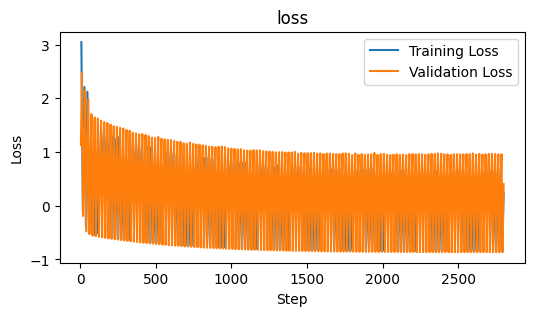

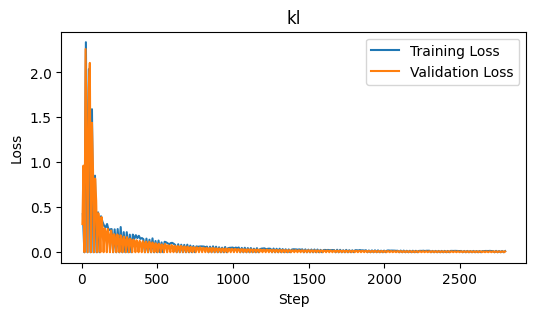

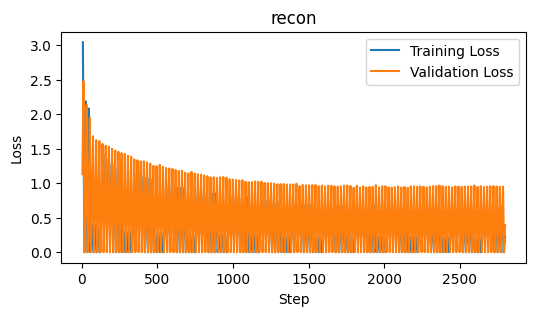

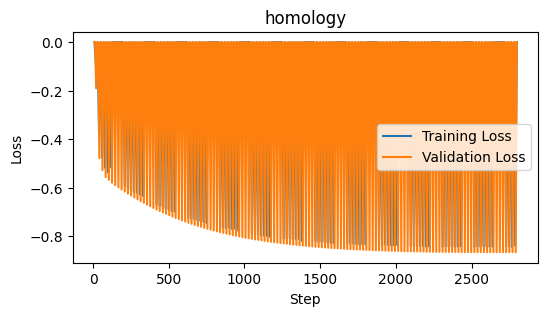

In [4]:
# Load the latest version
version = max([int(d.split('_')[-1]) for d in glob('logs/metrics/version_*')])
df = pd.read_csv(f'logs/metrics/version_{version}/metrics.csv')


for loss_type in ["loss", "kl", "recon", "homology"]:
    # Get specific metrics
    train_loss = df[f'train_{loss_type}']
    f1 = ~train_loss.isna()
    val_loss =  df[f'val_{loss_type}']
    f2 = ~val_loss.isna()

    # Plot
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6, 3))
    plt.plot(df['step'][f1], train_loss[f1], label='Training Loss')
    plt.plot(df['step'][f2], val_loss[f2], label='Validation Loss')

    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title(loss_type)
    plt.legend()

    
# best_model_path = trainer.callbacks[-1].best_model_path
# print("Best model path:", best_model_path)
# # Load the checkpoint
# checkpoint = torch.load(best_model_path)

# # Create a new model with the same hyperparameters and homology information
# model = CrossSpeciesVAE(
#     # homology_edges=homology_edges,  # Need to pass these again
#     **checkpoint['hyper_parameters']  # This loads all other hyperparameters
# )

# # Load the state dict
# model.load_state_dict(checkpoint['state_dict'])

0.55011499262598
0.4452466942020319
0.5911607808370292


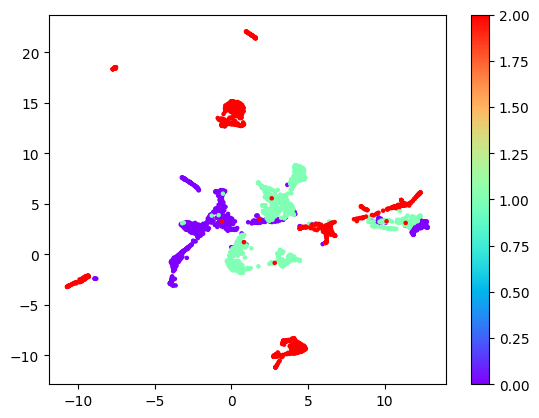

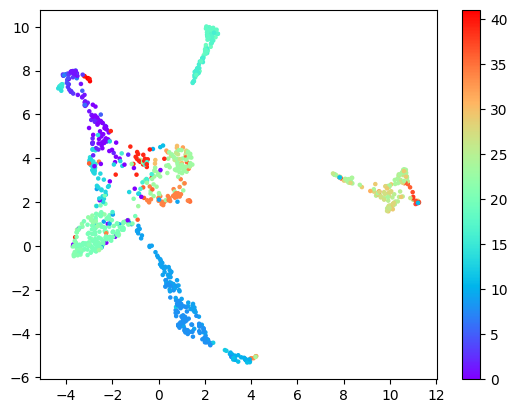

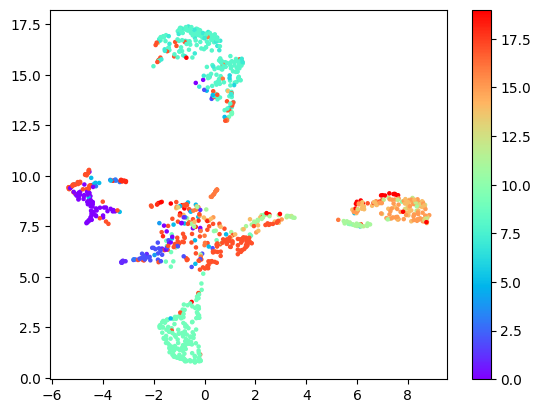

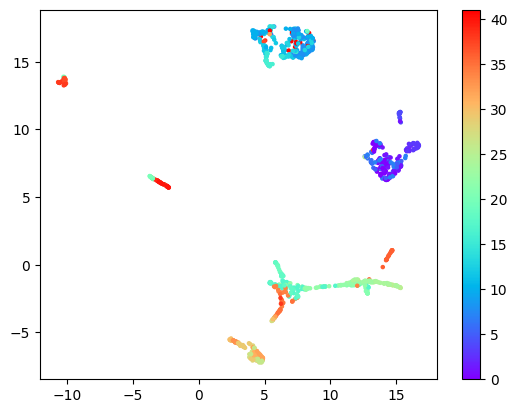

In [5]:


output, s = model.get_latent_embeddings(species_data, fusion=False)
s=s.cpu().numpy()

plt.figure();
dt_full = umap.UMAP(n_components=2).fit_transform(output.cpu().numpy())
plt.scatter(dt_full[:,0],dt_full[:,1], c = s,s=5, cmap='rainbow'); plt.colorbar()

for i, adata, key in zip([0, 1, 2], [adata1, adata2, adata3], ['cluster', 'cluster_t', 'Cluster']):
    dt = umap.UMAP(n_components=2).fit_transform(output[s==i])

    adata.obsm['emb'] = dt
    sc.pp.neighbors(adata, use_rep='emb')
    sc.tl.leiden(adata, flavor="igraph", n_iterations=2, resolution=2)
    print(adjusted_mutual_info_score(adata.obs[key], adata.obs['leiden']))
    
    plt.figure();
    plt.scatter(dt[:,0],dt[:,1], c = adata.obs[key].cat.codes,s=5, cmap='rainbow'); plt.colorbar()
    

0
pearson 0.35350110616168356
spearman 0.3539422488041138
1
pearson 0.30720247048017885
spearman 0.17862819498607413
2
pearson 0.5770984490031539
spearman 0.8327277149863773


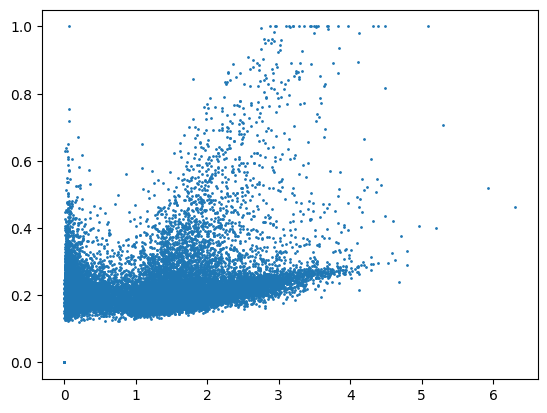

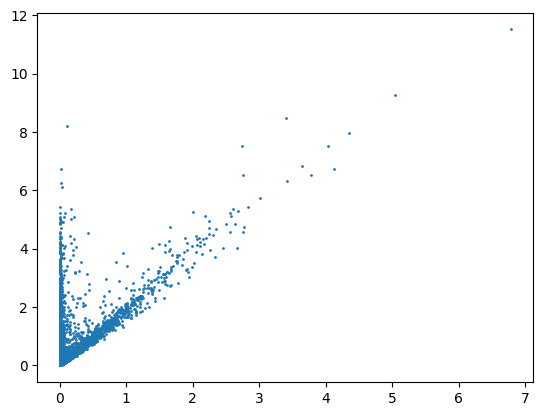

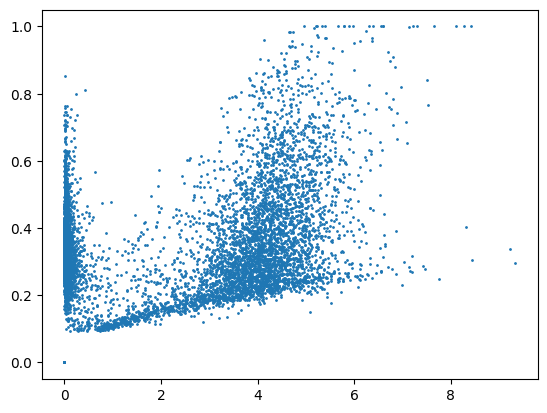

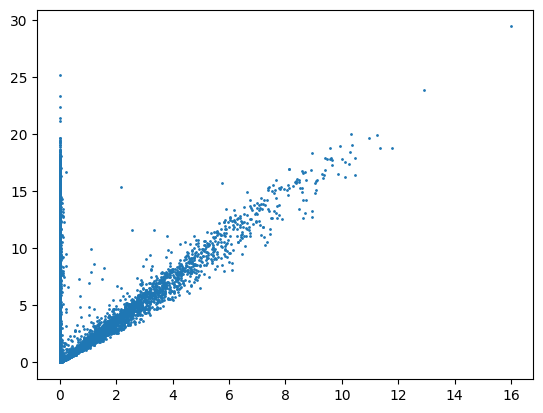

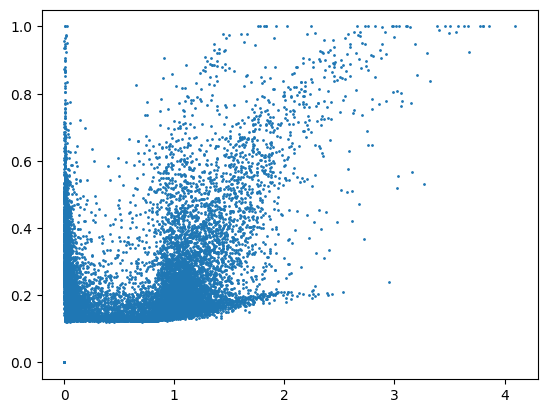

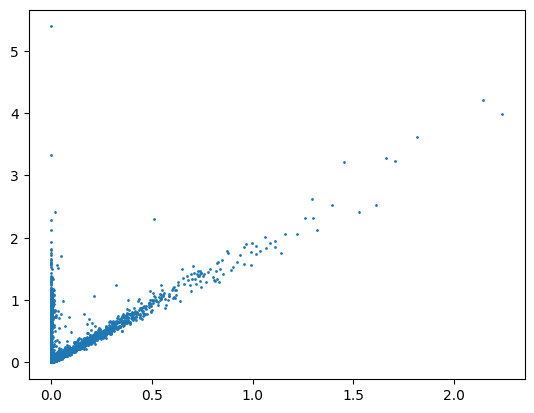

In [6]:
from scipy.stats import spearmanr

for i, adata in enumerate([adata1, adata2, adata3]):
    x = model.encoders[str(i)].gene_importance(torch.tensor(adata.X.toarray()).to('cuda')).detach().cpu().numpy()
    mu = x.mean(0)
    mu[mu==0]=1
    a = x.var(0)/mu
    b = adata.var['weights'].values

    plt.figure(); plt.scatter(a,b,s=1);
    plt.figure(); plt.scatter(x.var(0),adata.X.toarray().var(0),s=1);    
    print(i)
    print('pearson',np.corrcoef(a,b)[0,1])
    print('spearman',spearmanr(a,b).statistic)


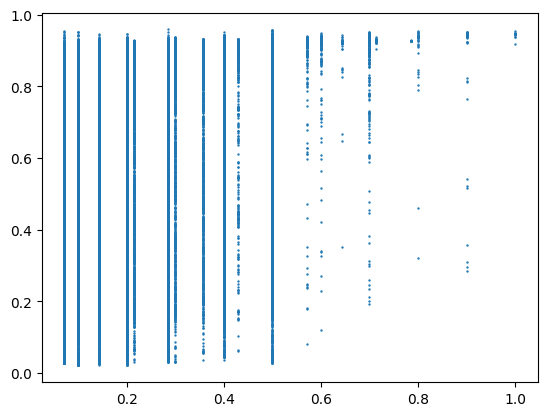

In [7]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

x=[]
y=[]
for i in range(len(set(s))):
    for j in range(i+1,len(set(s))):
        x.extend(homology_scores[i][j]/homology_scores[i][j].max())
        x.extend(homology_scores[j][i]/homology_scores[j][i].max())        
        y.extend(list(sigmoid(model.homology_scores[str(i)][str(j)].detach().cpu().numpy())))
        y.extend(list(sigmoid(model.homology_scores[str(j)][str(i)].detach().cpu().numpy())))
x=np.array(x)
y=np.array(y)
plt.figure(); plt.scatter(x,y,s=0.5);

In [8]:
latent = output.cpu().numpy()
adatas = []
for i, k in enumerate(species_data):
    adata = species_data[k]
    adata.obsm['emb'] = latent[s==i]
    adata.obs['species'] = k
    adatas.append(adata)

adata = anndata.concat(adatas,join='outer')
adata.obsm['X_umap'] = dt_full

adata.write_h5ad('test.h5ad')

In [10]:
import numpy as np
from pynndescent import NNDescent

def find_nearest_neighbors(L1, L2, n_neighbors=5, metric='euclidean'):
    """
    Finds the nearest neighbors from L1 (query) to L2 (index) using pynndescent.

    Parameters:
        L1 (np.ndarray): Query embeddings of shape (num_queries, embedding_dim).
        L2 (np.ndarray): Index embeddings of shape (num_index, embedding_dim).
        n_neighbors (int): Number of neighbors to find. Default is 5.
        metric (str): Distance metric to use. Default is 'euclidean'.

    Returns:
        indices (np.ndarray): Indices of nearest neighbors in L2 for each query in L1.
        distances (np.ndarray): Distances to nearest neighbors for each query in L1.
    """
    # Validate inputs
    if not isinstance(L1, np.ndarray) or not isinstance(L2, np.ndarray):
        raise ValueError("L1 and L2 must be numpy arrays.")
    
    if L1.shape[1] != L2.shape[1]:
        raise ValueError("L1 and L2 must have the same embedding dimension.")

    # Build the index on L2
    index = NNDescent(L2, metric=metric, n_neighbors=n_neighbors)
    
    # Query the nearest neighbors for L1
    indices, distances = index.query(L1, k=n_neighbors)
    
    return indices, distances

latent = output.cpu().numpy()

In [11]:
indices,distances = find_nearest_neighbors(latent[s==0],latent[s==1])

In [19]:
c1 = np.array(list(adata1.obs['tissue']))
c2 = np.array(list(adata2.obs['tissue']))

A = c1[np.tile(np.arange(c1.size)[:,None],(1,5))]
B = c2[indices]

In [26]:
a,c = np.unique(A + '--' + B,return_counts=True)
a[np.argsort(-c)]

array(['Neural--Neural', 'Neoblast--Cathepsin',
       'Epidermal--Tegument_prog', 'Epidermal--Cathepsin',
       'Epidermal--Neoblast', 'Cathepsin+ cells--Cathepsin',
       'Neoblast--Intestine', 'Neural--Parenchymal',
       'Cathepsin+ cells--Neural_KK7', 'Cathepsin+ cells--Neural',
       'Intestine--Cathepsin', 'Muscle--Parenchymal', 'Neural--Neoblast',
       'Muscle--Neural_KK7', 'Cathepsin+ cells--Parenchymal',
       'Neoblast--Muscle', 'Muscle--Neoblast', 'Neural--Muscle',
       'Pharynx--Neural', 'Muscle--Intestine', 'Neural--Flame cells',
       'Cathepsin+ cells--Intestine', 'Parapharyngeal--Muscle',
       'Intestine--Intestine', 'Neoblast--Neoblast', 'Neural--Cathepsin',
       'Protonephridia--Neural', 'Parapharyngeal--Neoblast',
       'Epidermal--Tegument', 'Muscle--Neural', 'Epidermal--Muscle',
       'Epidermal--Neural', 'Protonephridia--Cathepsin', 'Muscle--Gland',
       'Epidermal--Intestine', 'Intestine--Muscle',
       'Intestine--Tegument_prog', 'Neural--Int

In [23]:
pd.DataFrame(B[:20])

,0,1,2,3,4
0,Intestine,Cathepsin,Cathepsin,Neural_KK7,Cathepsin
1,Intestine,Cathepsin,Cathepsin,Neural_KK7,Cathepsin
2,Muscle,Intestine,Cathepsin,Cathepsin,Cathepsin
3,Cathepsin,Neoblast,Tegument_prog,Neoblast,Tegument_prog
4,Muscle,Cathepsin,Intestine,Cathepsin,Intestine
5,Muscle,Intestine,Muscle,Neural,Cathepsin
6,Cathepsin,Intestine,Cathepsin,Cathepsin,Parenchymal
7,Muscle,Neoblast,Parenchymal,Cathepsin,Neural
8,Cathepsin,Cathepsin,Intestine,Cathepsin,Cathepsin
9,Neural_KK7,Cathepsin,Gland,Neural_KK7,Parenchymal


In [15]:
B.shape

(1049, 5)

In [41]:
A1 = A[:1049].copy()
A1[i1 < 1049] = "nan"

B1 = B[:1049].copy()
B1[i1 < 1049] = "nan"

B1[:,0] = B[:1049,0]

In [46]:
i1

array([[   0,  293,  544,  531,  306],
       [   1,  449,  760,  329,  104],
       [   2,    5,  678,  840,  669],
       ...,
       [1046, 1509, 1841, 1347, 1924],
       [1047,  234,  412,  984,  479],
       [1048, 1001,  286,  966,  806]], dtype=int32)

In [43]:
pd.DataFrame(B1[(B1[:,1:]=='nan').sum(1) < 4])

,0,1,2,3,4
0,Neural: 1,nan,nan,nan,Neural: 23
1,Pharynx: 25,nan,nan,nan,Parapharyngeal: 12
2,Parapharyngeal: 12,nan,Parapharyngeal: 12,Parapharyngeal: 12,Neoblast: 0
3,Neural: 1,nan,Parapharyngeal: 12,i_smgc1,nan
4,Protonephridia: 26,Neoblast: 0,Neoblast: 0,Neoblast: 0,nan
5,Neural: 9,nan,nan,nan,Neural: 20
6,Neural: 9,nan,nan,nan,Neural: 23
7,Neoblast: 5,Muscle: 14,Muscle: 14,Muscle: 14,Muscle: 14
8,Parapharyngeal: 12,nan,nan,Parapharyngeal: 12,Muscle: 14
9,Neural: 36,nan,nan,enEp_head,nan


In [ ]:
A1

In [34]:
B1

array([['Intestine', 'nan', 'nan', 'nan', 'nan'],
       ['Intestine', 'nan', 'nan', 'nan', 'nan'],
       ['Neoblast', 'nan', 'nan', 'nan', 'nan'],
       ...,
       ['Epidermal', 'Neural', 'Neural', 'Parenchymal', 'Neural'],
       ['Neural', 'nan', 'nan', 'nan', 'nan'],
       ['Neural', 'nan', 'nan', 'nan', 'nan']], dtype='<U16')

In [28]:
i1

array([[   0,  293,  544,  531,  306],
       [   1,  449,  760,  329,  104],
       [   2,    5,  678,  840,  669],
       ...,
       [1046, 1509, 1841, 1347, 1924],
       [1047,  234,  412,  984,  479],
       [1048, 1001,  286,  966,  806]], dtype=int32)

In [27]:
A1

array([['nan', 'nan', 'nan', 'nan', 'nan'],
       ['nan', 'nan', 'nan', 'nan', 'nan'],
       ['nan', 'nan', 'nan', 'nan', 'nan'],
       ...,
       ['nan', 'Epidermal', 'Epidermal', 'Epidermal', 'Epidermal'],
       ['nan', 'nan', 'nan', 'nan', 'nan'],
       ['nan', 'nan', 'nan', 'nan', 'nan']], dtype='<U16')

In [37]:
c1[:20]

array([['Intestine', 'Intestine', 'Intestine', 'Intestine', 'Intestine'],
       ['Intestine', 'Intestine', 'Intestine', 'Intestine', 'Intestine'],
       ['Neoblast', 'Neoblast', 'Neoblast', 'Neoblast', 'Neoblast'],
       ['Epidermal', 'Epidermal', 'Epidermal', 'Epidermal', 'Epidermal'],
       ['Neoblast', 'Neoblast', 'Neoblast', 'Neoblast', 'Neoblast'],
       ['Epidermal', 'Epidermal', 'Epidermal', 'Epidermal', 'Epidermal'],
       ['Cathepsin+ cells', 'Cathepsin+ cells', 'Cathepsin+ cells',
        'Cathepsin+ cells', 'Cathepsin+ cells'],
       ['Neural', 'Neural', 'Neural', 'Neural', 'Neural'],
       ['Neural', 'Neural', 'Neural', 'Neural', 'Neural'],
       ['Cathepsin+ cells', 'Cathepsin+ cells', 'Cathepsin+ cells',
        'Cathepsin+ cells', 'Cathepsin+ cells'],
       ['Muscle', 'Muscle', 'Muscle', 'Muscle', 'Muscle'],
       ['Epidermal', 'Epidermal', 'Epidermal', 'Epidermal', 'Epidermal'],
       ['Neoblast', 'Neoblast', 'Neoblast', 'Neoblast', 'Neoblast'],
       ['Epi

In [38]:
c2[:20]

array([['Parenchymal', 'Neoblast', 'Neoblast', 'Neural', 'Intestine'],
       ['Parenchymal', 'Neoblast', 'Neural', 'Neoblast', 'Intestine'],
       ['Neoblast', 'Parenchymal', 'Neoblast', 'Neoblast', 'Neural'],
       ['Parenchymal', 'Neoblast', 'Neoblast', 'Neural', 'Intestine'],
       ['Neoblast', 'Parenchymal', 'Neoblast', 'Neoblast', 'Neural'],
       ['Parenchymal', 'Neoblast', 'Neural', 'Neoblast', 'Intestine'],
       ['Neoblast', 'Parenchymal', 'Neoblast', 'Neoblast', 'Neural'],
       ['Neural', 'Muscle', 'Parenchymal', 'Neoblast', 'Neural'],
       ['Neoblast', 'Parenchymal', 'Neoblast', 'Neural', 'Neoblast'],
       ['Parenchymal', 'Neoblast', 'Tegument_prog', 'Neural', 'Neoblast'],
       ['Parenchymal', 'Neoblast', 'Neural', 'Neoblast', 'Intestine'],
       ['Neoblast', 'Parenchymal', 'Neoblast', 'Neural', 'Neoblast'],
       ['Neoblast', 'Parenchymal', 'Neoblast', 'Neoblast', 'Neoblast'],
       ['Parenchymal', 'Neural', 'Neoblast', 'Neoblast', 'Intestine'],
       ['Ne